In [1]:
temperature = 0.8
root_folder = f'/private/home/dpf/projects/codex/'
globs = f'out/gpt-j_ncg-20_temp-{temperature}/default_*/responses.pkl'

In [2]:
import sys

In [3]:
sys.path.append(root_folder)

In [4]:
import glob
import pickle
import os

In [5]:
from models import Model

couldn't import torch; won't be able to use most models


In [6]:
import numpy as np

In [7]:
from human_eval.data import read_problems
from human_eval.evaluation import evaluate_functional_correctness

In [8]:
def unpickle(fname):
    print(fname)
    with open(fname, 'rb') as f:
        return pickle.load(f)

In [9]:
def all_equal(xs):
    xs = list(xs)
    return [x == xs[0] for x in xs]

In [10]:
def combine_responses(list_of_responses):
    list_of_responses = list(list_of_responses)
    assert all_equal(resp.keys() for resp in list_of_responses)
    responses = {}
    for resp in list_of_responses:
        for problem_id in resp:
            if problem_id not in responses:
                responses[problem_id] = {'choices': []}
            responses[problem_id]['choices'].extend(resp[problem_id]['choices'])
    return responses

In [11]:
pdb on

Automatic pdb calling has been turned ON


In [12]:
responses = combine_responses(
    unpickle(fname) for fname in glob.glob(os.path.join(root_folder, globs))
)

/private/home/dpf/projects/codex/out/gpt-j_ncg-20_temp-0.8/default_1/responses.pkl
/private/home/dpf/projects/codex/out/gpt-j_ncg-20_temp-0.8/default_6/responses.pkl
/private/home/dpf/projects/codex/out/gpt-j_ncg-20_temp-0.8/default_2/responses.pkl
/private/home/dpf/projects/codex/out/gpt-j_ncg-20_temp-0.8/default_8/responses.pkl
/private/home/dpf/projects/codex/out/gpt-j_ncg-20_temp-0.8/default_7/responses.pkl
/private/home/dpf/projects/codex/out/gpt-j_ncg-20_temp-0.8/default_10/responses.pkl
/private/home/dpf/projects/codex/out/gpt-j_ncg-20_temp-0.8/default_4/responses.pkl
/private/home/dpf/projects/codex/out/gpt-j_ncg-20_temp-0.8/default_3/responses.pkl
/private/home/dpf/projects/codex/out/gpt-j_ncg-20_temp-0.8/default_5/responses.pkl
/private/home/dpf/projects/codex/out/gpt-j_ncg-20_temp-0.8/default_9/responses.pkl


In [13]:
len(next(iter(responses.values()))['choices'])

200

In [14]:
len(next(iter(responses.values()))['choices'])

200

In [15]:
model = Model()

In [16]:
problems = list(sorted(read_problems().items()))

In [17]:
import random

In [25]:
def run_trial(responses, num_candidates, candidate_scoring):
    samples_to_evaluate = []
    for task_id, problem in problems:
        candidates = responses[task_id]['choices'].copy()
        random.shuffle(candidates)
        candidates = candidates[:num_candidates]
        completions, response = model.rank_completions(
            problem['prompt'], None, 
            cached_response={'choices': candidates},
            scoring=candidate_scoring,
        )
        best_score, best_candidate = completions[0]
        samples_to_evaluate.append(dict(
            task_id=task_id,
            completion=best_candidate
        ))
    return evaluate_functional_correctness(
        sample_file=None, samples=samples_to_evaluate,
        n_workers=4, suppress=True,
    )

In [19]:
def compute_oracle_scores(responses, all_num_candidates):
    samples_to_evaluate = []
    for task_id, problem in problems:
        choices = responses[task_id]['choices']
        assert max(all_num_candidates) <= len(choices), f"can't compute oracle; too few candidates ({len(choices)}) for id {task_id}"
        for choice in choices:
            samples_to_evaluate.append(dict(
                task_id=task_id, 
                completion=choice['text']
            ))
    results, extra = evaluate_functional_correctness(
        sample_file=None, samples=samples_to_evaluate,
        n_workers=20, suppress=False,
    )
    datapoints = []
    for num_candidates in all_num_candidates:
        datapoints.append({
            'num_candidates': num_candidates,
            'candidate_scoring': 'oracle',
            'pass@1': results[f'pass@{num_candidates}'],
        })
    return datapoints

In [20]:
datapoints = compute_oracle_scores(responses, [1, 10, 100])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32800/32800 [00:02<00:00, 11826.52it/s]


Running test suites...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32800/32800 [1:02:33<00:00,  8.74it/s]


In [21]:
# all_num_candidates = list(np.arange(9) + 1) + list((np.arange(10) + 1) * 10)
#all_num_candidates = [1, 10, 100]
all_num_candidates = [1, 2, 5, 10, 20, 50, 100]
all_num_candidates

[1, 2, 5, 10, 20, 50, 100]

In [23]:
from itertools import product

In [26]:
all_extras = {}
def log_trial(tpl):
    scoring_method, num_candidates, trial = tpl
    result, extras = run_trial(responses, num_candidates, scoring_method)
    result['num_candidates'] = num_candidates
    result['candidate_scoring'] = scoring_method
    result['trial'] = trial
    all_extras[tuple(tpl)] = extras
    return result

scoring_methods = ['sum', 'mean', 'random']
trials = list(range(3))

# datapoints = [
#     {'num_candidates': 1, 'candidate_scoring': 'oracle', 'pass@1': 10.6/100},
#     {'num_candidates': 10, 'candidate_scoring': 'oracle', 'pass@1': 26.4/100},
#     {'num_candidates': 100, 'candidate_scoring': 'oracle', 'pass@1': 43.9/100},
# ]

from multiprocessing.pool import ThreadPool
import tqdm
with ThreadPool(5) as pool:
    it = list(product(scoring_methods, all_num_candidates, trials))
    results = tqdm.tqdm(pool.imap(log_trial, it), total=len(it))
    datapoints.extend(results)

 27%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 17/63 [06:54<18:37, 24.29s/it]/private/home/dpf/projects/codex/models.py:33: RuntimeWarning: Mean of empty slice.
  return token_logprobs.mean()
/private/home/dpf/.conda/envs/analysis/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [22:46<00:00, 21.69s/it]


In [40]:
# datapoints = [
#     {'num_candidates': 1, 'candidate_scoring': 'oracle', 'pass@1': 6.1/100},
#     {'num_candidates': 10, 'candidate_scoring': 'oracle', 'pass@1': 16.3/100},
#     {'num_candidates': 100, 'candidate_scoring': 'oracle', 'pass@1': 30.8/100},
# ]
# for scoring_method in ['sum', 'mean', 'random']:
#     for num_candidates in all_num_candidates:
#         for trial in range(3):
#             result = run_trial(responses, num_candidates, scoring_method)
#             result['num_candidates'] = num_candidates
#             result['candidate_scoring'] = scoring_method
#             result['trial'] = trial
#             datapoints.append(result)

In [27]:
import pandas

In [28]:
df = pandas.DataFrame(datapoints)

In [29]:
df.columns

Index(['num_candidates', 'candidate_scoring', 'pass@1', 'trial'], dtype='object')

In [30]:
means = df.groupby(['num_candidates','candidate_scoring'])['pass@1'].mean()

In [31]:
means

num_candidates  candidate_scoring
1               mean                 0.044715
                oracle               0.060549
                random               0.052846
                sum                  0.060976
2               mean                 0.071138
                random               0.058943
                sum                  0.075203
5               mean                 0.077236
                random               0.052846
                sum                  0.073171
10              mean                 0.081301
                oracle               0.162887
                random               0.050813
                sum                  0.054878
20              mean                 0.050813
                random               0.067073
                sum                  0.058943
50              mean                 0.063008
                random               0.048780
                sum                  0.034553
100             mean                 0.063008


In [32]:
import matplotlib.pyplot as plt

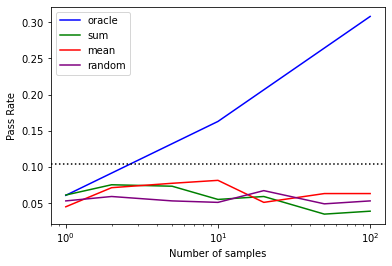

In [33]:
r = means.reset_index()
ax = None
for scoring, color in [('oracle', 'b'), ('sum', 'g'), ('mean', 'r'), ('random', 'purple')]:
    col = r[r['candidate_scoring'] == scoring]
    ax = col.plot(
        x='num_candidates', y='pass@1', color=color, label=scoring, logx=True,
        ax=ax,
    )
plt.legend()
plt.xlabel('Number of samples')
plt.ylabel('Pass Rate')
plt.axhline(.104, c='k', linestyle=':')

In [35]:
from collections import defaultdict

In [36]:
def pool_by_problem(all_extras, filter_fn=None):
    completion_lengths_by_problem = defaultdict(list)
    for tpl, d in all_extras.items():
        if filter_fn is not None and not filter_fn(tpl):
            continue
        for k, vs in d['completion_lengths'].items():
            completion_lengths_by_problem[k].extend(vs)
    return completion_lengths_by_problem

In [37]:
np.mean(list({k: np.mean(v) for k, v in pool_by_problem(all_extras, filter_fn=lambda t: t[0] == 'random' and t[1] == 100).items()}.values()))

326.6626016260163

In [38]:
np.mean(list({k: np.mean(v) for k, v in pool_by_problem(all_extras, filter_fn=lambda t: t[0] == 'sum' and t[1] == 100).items()}.values()))

35.17276422764228

In [39]:
np.mean(list({k: np.mean(v) for k, v in pool_by_problem(all_extras, filter_fn=lambda t: t[0] == 'mean' and t[1] == 100).items()}.values()))

493.10772357723573